In [50]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..','..','..'))
from ursse.hydra_harp_file_reader import HydraHarpFile
from ursse.LED_tests.data_analyzis import calc_Fano, get_time_window_hist, calc_Fano_from_counts_per_time_window
import numpy as np
import pandas as pd
import seaborn as sns
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 20,'legend.fontsize':20})
import ursse.path_assistant as pa
shift = pa.PathAssistant('shift_02_28_2020')

In [51]:
df, n_revolutions = read_event_delays(shift.get_time_stamp_file_path('1el_002.ptu'))
t_delays = df.delay

In [52]:
gate = (61000, 66000)
dt=0.1  # sec

In [53]:
n = 500
i = 200

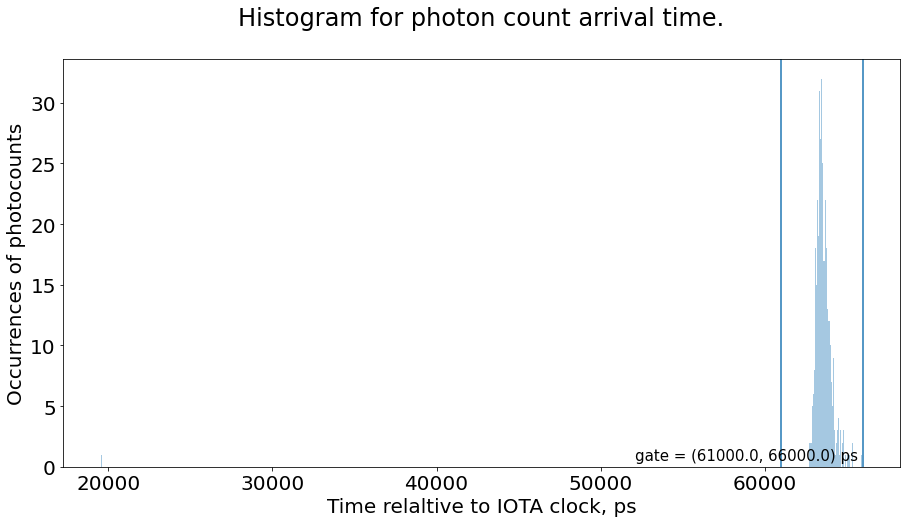

In [54]:
plot_arrival_time_hist(t_delays[i*n:(i+1)*n], gate=gate, bins=1000, yscale='linear')

In [55]:
n_revolutions*133e-9

59.866547461

In [56]:
t_delays_in_gate = t_delays[t_delays.between(gate[0],gate[1])]

In [57]:
len(t_delays_in_gate)/n_revolutions/133e-9

24722.22071874391

In [58]:
from config_ursse import get_from_config
iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
iota_period_au = iota_period_sec/dt_sec

In [59]:
from ursse.time_structure import get_bucket_gates, get_rate_in_gate_Hz

In [60]:
four_gates = get_bucket_gates(gate)
four_gates

[(61000.0, 66000.0),
 (94250.0, 99250.0),
 (127500.00000000001, 132500.0),
 (27750.0, 32750.0)]

In [61]:
get_rate_in_gate_Hz(df, n_revolutions, gate)

24722.22071874391

In [62]:
bucket_dfs = [df[(df.delay > gate[0]) & (df.delay < gate[1])] for gate in four_gates]

In [63]:
df0 = bucket_dfs[0]

In [64]:
revolutions_per_dt = dt/iota_period_sec
revolutions_per_dt

751879.6992481203

In [65]:
df0['index_of_dt_bin'] = (df0.revolution/revolutions_per_dt).astype(int)
df0['time_sec'] = df0['index_of_dt_bin']*dt

<ipython-input-65-27c4b84eb6f7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-65-27c4b84eb6f7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



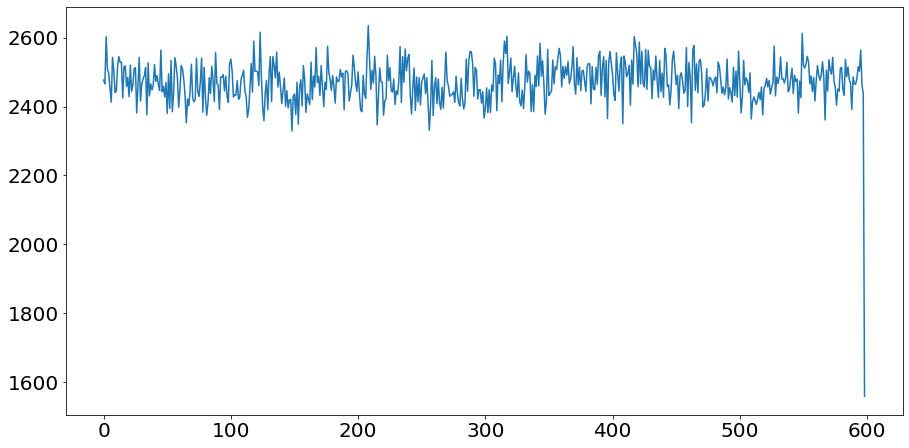

In [66]:
plt.plot(df0.groupby('index_of_dt_bin').delay.count())

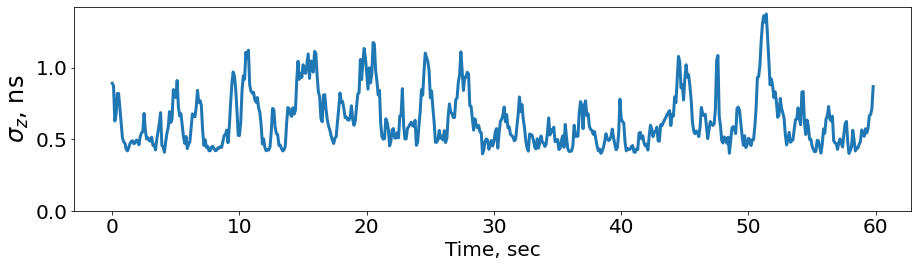

In [83]:
fig, ax = plt.subplots(figsize=(15, 3.75))
ax.plot(df0.groupby('index_of_dt_bin')['index_of_dt_bin'].mean()*dt, df0.groupby('index_of_dt_bin').delay.std()/1000,
        linewidth=3)
ax.set_xlabel('Time, sec')
ax.set_ylabel('$\sigma_z$, ns', fontsize=24)
ax.set_ylim(0, ax.get_ylim()[1])
plt.show()

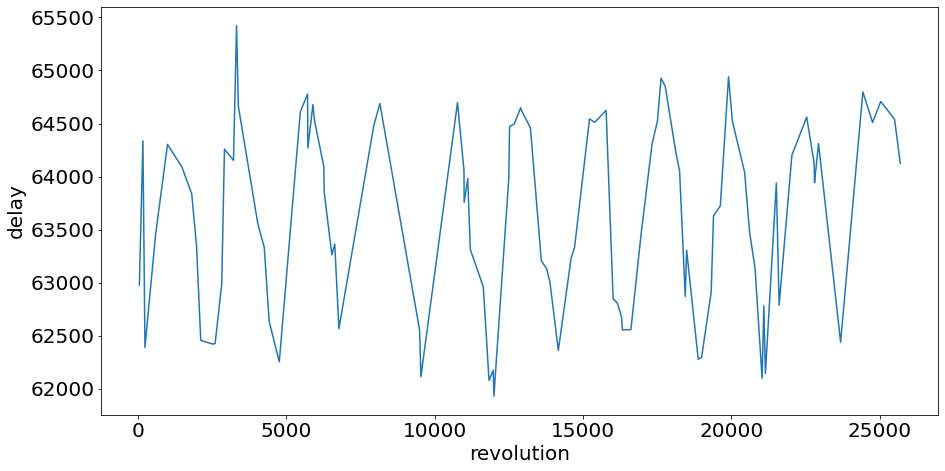

In [68]:
i = 0
m = 100
sns.lineplot(data=df0.iloc[i*m:(i+1)*m,:], x='revolution', y='delay')

In [69]:
import plotly.express as px

In [70]:
df0

,revolution,delay,index_of_dt_bin,time_sec
51,51,62977.0,0,0.0
172,171,64337.0,0,0.0
241,239,62389.0,0,0.0
601,598,63454.0,0,0.0
1004,999,64303.0,0,0.0
...,...,...,...,...
452639788,450123392,63592.0,598,59.8
452640074,450123677,62846.0,598,59.8
452640278,450123880,62373.0,598,59.8
452640330,450123931,62842.0,598,59.8


In [71]:
nbins=30
y_max = df0.groupby('index_of_dt_bin').delay.apply(lambda x: max(np.histogram(np.asarray(x), bins=nbins, range=gate)[0])).max()

In [72]:
bins = np.histogram([], bins=nbins, range=gate)[1]
bin_centers = (bins[1:]+bins[:-1])/2

In [73]:
hists = (df0.groupby('index_of_dt_bin').delay.apply(lambda x: np.histogram(np.asarray(x), bins=nbins, range=gate)[0])).to_list()

In [74]:
n_dt_bins = int(n_revolutions/revolutions_per_dt)

In [75]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
y_max = np.concatenate(hists)[:nbins*n_dt_bins].max()

In [109]:
gate_ns = (gate[0]/1000, gate[1]/1000)

In [116]:
plt.rcParams.update({'font.size': 24,'legend.fontsize':24})

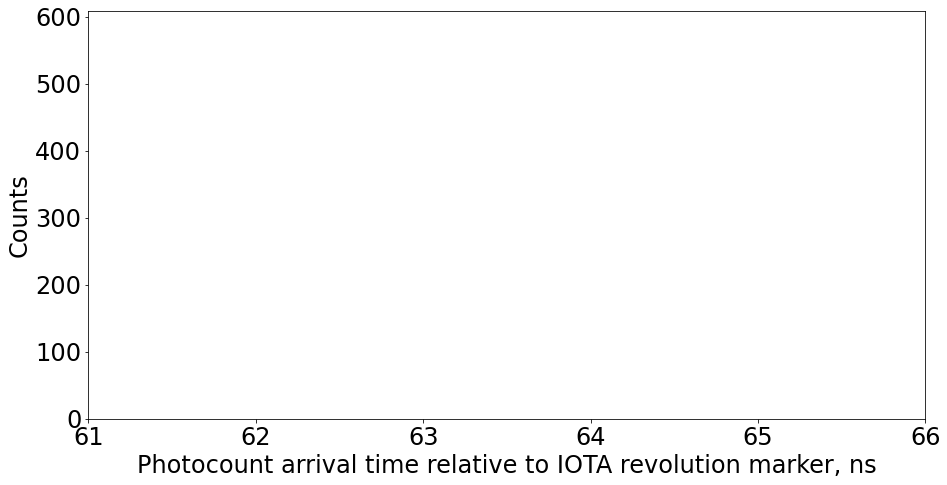

In [117]:
fig, ax = plt.subplots()

ax.set_xlim(gate_ns)
ax.set_ylim((0, 1.1*y_max))
ax.set_xlabel('Photocount arrival time relative to IOTA revolution marker, ns')
ax.set_ylabel('Counts')
line, = ax.plot([], [], lw=2, color='blue')

In [118]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [119]:
from scipy import interpolate

In [120]:
# animation function. This is called sequentially
def animate(i):
    x0 = bin_centers/1000
    y0 = hists[i]
    x = np.linspace(min(x0), max(x0), 100)
    f = interpolate.interp1d(x0, y0, kind='cubic')
    y = f(x)
    line.set_data(x, y)
    ax.collections.clear()
    ax.fill_between(x, 0, y, facecolor='blue')
    return (line,)

In [121]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_dt_bins, interval=int(dt*1000), blit=True)

In [122]:
anim

In [44]:
anim.save('animation.gif', writer='imagemagick', fps=60)

MovieWriter stderr:
convert: DistributedPixelCache '127.0.0.1' @ error/distribute-cache.c/ConnectPixelCacheServer/244.
convert: cache resources exhausted `-' @ error/cache.c/OpenPixelCache/3984.
convert: no images defined `animation.gif' @ error/convert.c/ConvertImageCommand/3258.



CalledProcessError: Command '['/usr/bin/convert', '-size', '1080x540', '-depth', '8', '-delay', '1.6666666666666667', '-loop', '0', 'rgba:-', 'animation.gif']' returned non-zero exit status 1.

In [27]:
all_bin_centers = np.tile(bin_centers, n_dt_bins)
all_hists = np.concatenate(hists)[:nbins*n_dt_bins]
all_indexes = np.ravel(np.ones(bin_centers.shape)*(np.arange(n_dt_bins)[:, None])).astype(int)
hist_df = pd.DataFrame({'bin_center': all_bin_centers,
                        'counts': all_hists,
                        'time_index':all_indexes})
hist_df['time_sec'] = dt*hist_df['time_index']
y_max = hist_df['counts'].max()

In [28]:
hist_df

,bin_center,counts,time_index,time_sec
0,61083.333333,0,0,0.0
1,61250.000000,0,0,0.0
2,61416.666667,0,0,0.0
3,61583.333333,0,0,0.0
4,61750.000000,0,0,0.0
...,...,...,...,...
35905,65250.000000,18,1196,59.8
35906,65416.666667,5,1196,59.8
35907,65583.333333,6,1196,59.8
35908,65750.000000,5,1196,59.8


In [29]:
fig = px.bar(hist_df, x="bin_center", y="counts",
  animation_frame="time_index", range_x=gate, range_y=[0, 1.1*y_max])
fig.update_layout(
    xaxis_title="Photocount arrival time relative to IOTA revolution marker",
    yaxis_title="Counts",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = int(dt*1000)
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0
fig.show()

KeyboardInterrupt: 

In [ ]:
fig = px.histogram(df0, x="delay", nbins=nbins, animation_frame="index_of_dt_bin",
                   hover_data=df.columns, range_x=gate, range_y=[0,1.1*y_max])
fig.show()

In [ ]:
np.histogram([1,2,3,4,5], bins=5, range=(-10,10))

In [ ]:
px.histogram()

In [ ]:
import plotly.express as px

df = px.data.gapminder()

fig = px.bar(df, x="continent", y="pop", color="continent",
  animation_frame="year", animation_group="country", range_y=[0,4000000000])
fig.show()

In [ ]:
df

In [ ]:
df